# Stocks trading using Reinforcement Learning

This is an experiment using RL on stocks trading. It's only for fun, we won't be rich with this (or yes?).  

We have a stock **market** and many agents, we can use dummy agents and actor-critic agents. You can implement your own agent, training it and put it to compete with the other agents.  

In the market there's money and only one kind of product, the agents start with the same money and product quantity.  
The goal is earn money, the reward is the money that the agent has earned (negative if it lost money).

Thanks to the book:  
* Maxim Lapan. *Deep Reiforcement Learning Hands-On*

In [1]:
import random
import numpy as np
from collections import deque
from random import seed
from random import randint
from random import uniform


# Stats

Keep info about the market (price, total product quantity), the agents (products, money, reward) and about the agent training (losses, values).

In [2]:
class Stats:
    def __init__(self):
        self.history_market = {}
        self.history_agent = {}
        self.history_agent_training = {}
    
    def add_market_step(self, step, price, total_quantity):
        info = {'price': price,
               'total_quantity': total_quantity}
        self.history_market[step] = info
    
    def add_agent_step(self, index_agent, step, reward, action, action_quantity, action_price, money, quantity):
        info = {'reward': reward,
               'action_quantity': action_quantity,
               'action_price': action_price,
               'action':action,
               'money': money,
               'quantity': quantity}
        if index_agent not in self.history_agent:
            self.history_agent[index_agent] = {}
        self.history_agent[index_agent][step] = info
    
    def add_agent_training(self, index_agent, step, 
                           value_from_net, calculate_value, 
                           loss_action, loss_price, loss_quantity, loss_entropy, loss_value):
        info = {'value_from_net': value_from_net,
                'calculate_value': calculate_value,
                'loss_action': loss_action,
                'loss_price': loss_price,
                'loss_quantity': loss_quantity,
                'loss_entropy': loss_entropy,
                'loss_value': loss_value}
        if index_agent not in self.history_agent_training:
            self.history_agent_training[index_agent] = {}
        self.history_agent_training[index_agent][step] = info
    
    def get_price_history(self):
        ret = []
        for s in self.history_market:
            ret.append(self.history_market[s]['price'])
        return ret
    
    def get_total_quantity_history(self):
        ret = []
        for s in self.history_market:
            ret.append(self.history_market[s]['total_quantity'])
        return ret
    
    def get_agent_history(self, index_agent):
        ret = {'reward': [], 'money': [], 'quantity': []}
        for s in self.history_agent[index_agent]:
            ret['reward'].append(self.history_agent[index_agent][s]['reward'])
            ret['money'].append(self.history_agent[index_agent][s]['money'])
            ret['quantity'].append(self.history_agent[index_agent][s]['quantity'])
        return ret
    
    def get_agent_training_history(self, index_agent):
        ret = {'steps':[],
               'value_from_net': [], 
               'calculate_value': [], 
               'loss_action': [],
               'loss_price': [],
               'loss_quantity': [],
               'loss_entropy': [],
               'loss_value': []}
        for s in self.history_agent_training[index_agent]:
            ret['steps'].append(s)
            ret['value_from_net'].append(self.history_agent_training[index_agent][s]['value_from_net'])
            ret['calculate_value'].append(self.history_agent_training[index_agent][s]['calculate_value'])
            ret['loss_action'].append(self.history_agent_training[index_agent][s]['loss_action'])            
            ret['loss_price'].append(self.history_agent_training[index_agent][s]['loss_price'])
            ret['loss_quantity'].append(self.history_agent_training[index_agent][s]['loss_quantity'])
            ret['loss_entropy'].append(self.history_agent_training[index_agent][s]['loss_entropy'])
            ret['loss_value'].append(self.history_agent_training[index_agent][s]['loss_value'])
        return ret


## Environment

The enivorment is a market. The agents can buy and sell products for money.  
In each step the market will match sellers and buyers.  
The agents receive the feedback if they can sell/buy the product or not. The agents receive the reward too, how much money earn or lost (if negative).  


In [3]:

class Market:
    def __init__(self, stats):
        # Keep money and quantity for each agent
        self.accounts = []
        
        # keep for each agent the info and transactions of the last step.
        self.info_step = {}
        
        self.last_price = 0
        self.last_total_quantity = 0
        
        # how agents want to sell/buy.
        self.sellers = []
        self.buyers = []
    
        self.stats = stats
        
    # New episode
    def new_episode(self, amount_agents, start_money, start_quantity):
        self.accounts = []
        for i in range(amount_agents):
            self.accounts.append({'money': start_money, 'quantity': start_quantity})
        self.price_history = []
        self.price_step_history = []
        self.quantity_history = []
        self.quantity_step_history = []
    
    # Pay money to the agent
    def pay(self, index_agent, money):
        self.accounts[index_agent]['money'] += money
        
    # IMPORTANT! One agent cannot be a seller and a buyer at the same step.
    
    # The agent 'agent_index' put to sell 'quantity' of products.
    # Each unity of product to 'price'.
    # The agent can sell them to price or more.
    def sell(self, agent_index, quantity, price):
        if price <= 0:
            return False
        
        if self.accounts[agent_index]['quantity'] < quantity:
            return False
        
        self.sellers.append({'agent_index': agent_index, 'quantity': quantity, 'price': price})
        return True
    
    # The agent 'agent_index' wants buy 'quantity' of products.
    # Each unity of product to 'price'.
    # The agent can buy zero to quantity products and with price or less.
    def buy(self, agent_index, quantity, price):
        if price <= 0:
            return False
        
        if self.accounts[agent_index]['money'] < (quantity * price):
            return False
        
        self.buyers.append({'agent_index': agent_index, 'quantity': quantity, 'price': price})
        return True
    
    # Make a step, do transactions.
    def step(self, nro_step):
        self.info_step = {}
        
        def get_price(item):
            return item['price']
        
        # Order the sellers ascendent
        self.sellers.sort(key=get_price)
        
        # Order the buyers descendent
        self.buyers.sort(key=get_price, reverse=True)
        
        # Connect the first seller with the first buyer and make a transaction.
        # The transaction's price will be the mean price.
        # Continue until there's no more seller/buyer or there's no price coincidents.
        self.last_total_quantity = 0
        total_price = 0
        amount_price = 0
        while len(self.buyers) > 0 and len(self.sellers) > 0 \
                and self.buyers[0]['price'] >= self.sellers[0]['price']:
            
            index_buyer = self.buyers[0]['agent_index']
            index_seller = self.sellers[0]['agent_index']
            
            # Calculate the price and quantity for this transaction
            transaction_price = (self.buyers[0]['price'] + self.sellers[0]['price']) / 2
            transaction_quantity = min(self.buyers[0]['quantity'], self.sellers[0]['quantity'])
            
            # Update quantity and money
            self.accounts[index_buyer]['quantity'] += transaction_quantity
            self.accounts[index_buyer]['money'] -= transaction_quantity * transaction_price
            self.accounts[index_seller]['quantity'] -= transaction_quantity
            self.accounts[index_seller]['money'] += transaction_quantity * transaction_price
            
            # Make buyer struct
            if index_buyer not in self.info_step:
                self.info_step[index_buyer] = {'reward': 0, 'transactions': []}
            # Add transaction info for the buyer
            self.info_step[index_buyer]['transactions'].append({'type': 'buy',
                                                                'quantity': transaction_quantity, 
                                                                'price': transaction_price})
            # Update reward for the buyer (it lost money, negative reward)
            self.info_step[index_buyer]['reward'] -= transaction_quantity * transaction_price
            
            # Make seller struct
            if index_seller not in self.info_step:
                self.info_step[index_seller] = {'reward': 0, 'transactions': []}
            # Add transaction info for the seller
            self.info_step[index_seller]['transactions'].append({'type': 'sell',
                                                                'quantity': transaction_quantity, 
                                                                'price': transaction_price})
            # Update reward for the seller (it earn money, positive reward)
            self.info_step[index_seller]['reward'] += transaction_quantity * transaction_price
            
            # Update lists
            self.buyers[0]['quantity'] -= transaction_quantity
            self.sellers[0]['quantity'] -= transaction_quantity
            if self.buyers[0]['quantity'] <= 0:
                self.buyers.pop(0)
            if self.sellers[0]['quantity'] <= 0:
                self.sellers.pop(0)
                
            # Calculate price and total quantity
            total_price += transaction_price
            amount_price += 1
            self.last_total_quantity += transaction_quantity
        
        # Last price as the average of the step
        if amount_price > 0:
            self.last_price = total_price / amount_price
            
        # Add to stats
        self.stats.add_market_step(nro_step, self.last_price, self.last_total_quantity)
        
        self.sellers = []
        self.buyers = []
    
    def get_money(self, index_agent):
        return self.accounts[index_agent]['money']
    
    def get_quantity(self, index_agent):
        return self.accounts[index_agent]['quantity']

    def get_result(self, index_agent):
        if index_agent not in self.info_step:
            return None
        else:
            return self.info_step[index_agent]
    
    def get_last_price(self):
        return self.last_price
    
    def get_last_total_quantity(self):
        return self.last_total_quantity

    def get_moneys(self):
        ret = []
        for a in self.accounts:
            ret.append(a['money'])
        return ret
    
    def get_quantities(self):
        ret = []
        for a in self.accounts:
            ret.append(a['quantity'])
        return ret
    

# Agents

## Dummy agent
Sell and buy products randomly.  

In [4]:
class DummyAgent:
    def __init__(self, index, start_money, start_quantity, stats):
        self.index = index
        self.last_action = {'action':'nothing', 'quantity':0, 'price':0}
        self.stats = stats
    
    def get_name(self):
        return "Dummy "+(str(self.index).zfill(4))
    
    # State: [quantity, money, price, total_quantity]
    # Return: {<'nothing','buy','sell'>, quantity, price}
    def get_action(self, state, nro_step):
        my_money = state[1]
        my_quantity = state[0]
        
        action = randint(0, 3)
        action_string = 'nothing'
        action_quantity = 0
        action_price = 0
        if action == 0: # sell
            action_string = 'sell'
            action_quantity = randint(0, my_quantity+1)
            action_price = uniform(0, my_money)
        elif action == 1: # buy
            action_string= 'buy'
            action_quantity = randint(0, my_quantity+1)+1
            action_price = uniform(0, my_money)+1
        
        self.last_action = {'action':action_string, 'quantity':action_quantity, 'price':action_price}
            
        return self.last_action
    
    # transactions: {'type' ('buy' or 'sell'), 'quantity', 'price'}
    # reward: how many money I earn or lost in the last step
    def feedback(self, transactions, reward, next_state, nro_step):
        my_money = next_state[1]
        my_quantity = next_state[0]
            
        self.stats.add_agent_step(self.index, nro_step, reward, 
                                  self.last_action['action'], self.last_action['quantity'], self.last_action['price'], 
                                  my_money, my_quantity)
        
        if result is None:
            pass
        else:
            pass
            #{'type': 'buy',
            #'amount': 1,
            #'quantity': transaction_quantity, 
            #'last_price': transaction_price}
        

## Actor-Critic agent


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math

In [6]:
# Test if cuda is avaliable for torch
print("Cuda avaliable: "+str(torch.cuda.is_available()))

# Test how many cuda device are in torch
print("Cuda device: "+str(torch.cuda.device_count()))

Cuda avaliable: True
Cuda device: 1


### The neural network that implements the actor-critic agent behavior

It receive the state as input (my_quantity_product, my_money, last_product_price, total_quantity).  
The network output is:  
* The action: (buy, sell, nothing)
* quantity and price mu: mean of normal probability to get the quantity and price of the action
* quantity and price var: variance of normal probability to get the quantity and price of the action
* value: The critic value of the state

In [7]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.dense_base = nn.Sequential(
            nn.Linear(4, 24),
            nn.Sigmoid(),
            nn.Linear(24, 24),
            nn.Sigmoid() )
        
        self.dense_out_action = nn.Sequential(
            nn.Linear(24, 3) )
        
        # Quantity and price is defined by a normal(mu,var)
        self.dense_out_quantity_price_mu = nn.Sequential(
            nn.Linear(24, 2),
            nn.Softplus())
        self.dense_out_quantity_price_var = nn.Sequential(
            nn.Linear(24, 2),
            nn.Softplus() )
        
        self.dense_out_value = nn.Sequential(
            nn.Linear(24, 24),
            nn.Linear(24, 1) )
        
    def forward(self, state):
        x = self.dense_base(state)
        
        action_out = self.dense_out_action(x)
        action_out_q_p_mu = self.dense_out_quantity_price_mu(x)
        action_out_q_p_var = self.dense_out_quantity_price_var(x)
        
        value_v = self.dense_out_value(x)
        
        return action_out, action_out_q_p_mu, action_out_q_p_var, value_v
        

### Actor-Critic agent

It's on-policy then we can't use replay buffer. The agent recollects the experience with the last policy and then pick a batch to train, finally clear the memory because it needs to fill it with fresh experience.  

The entropy makes the agent keeps the exploration when its actions become too certain. The loss entropy is minimum when the policy is unfirom and maximum when has only one action to 100%.  


In [8]:
GAMMA = 0.99
LEARNING_RATE = 0.01

# Only one because we do an action and the reward is instantly
N_REWARD_STEPS = 1

# Each agent randomly get a memory size, this prevent they update their nets at the same time.
MEMORY_SIZE_MIN = 20
MEMORY_SIZE_MAX = 25

BATCH_SIZE = 8

ENTROPY_BETA = 0.1

class RLAgent:
    def __init__(self, index, start_money, start_quantity, stats):
        self.index = index
        
        self.memory = []
        self.memory_size = random.randint(MEMORY_SIZE_MIN, MEMORY_SIZE_MAX)
        
        self.last_state = None
        self.last_action = {'action':'nothing', 'quantity':0, 'price':0}
        
        self.platform = 'cpu'
        self.net = Net().to(self.platform)
        self.optimizer = optim.Adam(self.net.parameters(), lr=LEARNING_RATE)
        
        self.stats = stats
    
    def get_name(self):
        return "ActorCritic "+(str(self.index).zfill(4))
    
    # State: [quantity, money, price, amount_quantity]
    # Return: {<'nothing','buy','sell'>, quantity, price}
    def get_action(self, state, nro_step):
        my_money = state[1]
        my_quantity = state[0]
        
        # Current state
        np_state = np.array([state])
        
        # Get action
        action, action_quantity, action_price = self.predict(np_state, True)
        ret_action = {'action':'nothing', 'quantity':action_quantity, 'price':action_price}
        
        if action == 0: # sell
            ret_action['action'] = 'sell'
        elif action == 1: # buy
            ret_action['action'] = 'buy'
        
        self.last_state = state
        self.last_action = ret_action
        
        return ret_action
        
    # transactions: {'type' ('buy' or 'sell'), 'quantity', 'price'}
    # reward: how many money I earn or lost in the last step
    def feedback(self, transactions, reward, next_state, nro_step):
        my_money = next_state[1]
        my_quantity = next_state[0]
        
        # Add to memory
        self.memory.append((self.last_state, self.last_action, reward, next_state))
            
        self.stats.add_agent_step(self.index, 
                                  nro_step, 
                                  reward, 
                                  self.last_action['action'], self.last_action['quantity'], self.last_action['price'], 
                                  my_money, my_quantity)
        
            
        if len(self.memory) < self.memory_size or len(self.memory) < (BATCH_SIZE + N_REWARD_STEPS):
            return
        else:
            
            # Get random batch from memory
            batch_index_memory = random.sample([*range(len(self.memory) - N_REWARD_STEPS)], BATCH_SIZE)
            
            # Process the batch
            batch_states = []
            batch_actions = []
            batch_q_p = []
            batch_rewards_nsteps = []
            batch_last_states = []
            
            for index in batch_index_memory:
                
                state, action, reward, next_state = self.memory[index]
                
                batch_states.append(state)
                
                # Add action
                if action['action'] == 'sell':
                    batch_actions.append(0)
                elif action['action'] == 'buy':
                    batch_actions.append(1)
                else:
                    batch_actions.append(2)
                batch_q_p.append([ action['quantity'], action['price'] ])
                
                # Calculate value using n-steps.
                value = reward
                for i in range(1, N_REWARD_STEPS):
                    _, _, reward2, _ = self.memory[i+index]
                    value += GAMMA ** i * reward2
                batch_rewards_nsteps.append(value)
                last_state, _, _, _ = self.memory[index+N_REWARD_STEPS]
                batch_last_states.append(last_state)

            # Bring batch to platform memory
            batch_states_v = torch.FloatTensor(batch_states).to(self.platform)
            batch_actions_t = torch.LongTensor(batch_actions).to(self.platform)
            batch_q_p_v = torch.FloatTensor(batch_q_p).to(self.platform)
            batch_last_states_v = torch.FloatTensor(batch_last_states).to(self.platform)
            
            # Reset gradient of the net
            self.net.zero_grad()
            
            # Get action and value from net
            logits_action_out_v, q_p_mu_out_v, q_p_var_out_v, value_v = self.net(batch_states_v)
            
            # Backpropagate value
            _, _, _, values_last_v = self.net(batch_last_states_v)
            values_last = values_last_v.squeeze(-1).data.cpu().numpy()
            batch_values = batch_rewards_nsteps + GAMMA ** N_REWARD_STEPS * values_last
            batch_values_v = torch.FloatTensor(batch_values).to(self.platform)
            loss_value_v = F.mse_loss(value_v.squeeze(-1), batch_values_v) 
            
            # Calculate log prob of the action
            log_action_out_v = F.log_softmax(logits_action_out_v, dim=1)
            p1 = - ((q_p_mu_out_v - batch_q_p_v) ** 2) / (2*q_p_var_out_v.clamp(min=1e-3))
            p2 = - torch.log(torch.sqrt(2 * math.pi * q_p_var_out_v))
            log_q_p_out_v = p1 + p2
            
            # Backpropagate action loss
            # Action loss
            adv_v = batch_values_v - value_v.squeeze(-1).detach() # A(s,a) = Q(s,a) - V(s)
            log_prob_actions_v = adv_v * log_action_out_v[range(BATCH_SIZE), batch_actions_t]
            loss_policy_action_v = -log_prob_actions_v.mean()
            # Quantity and price loss
            log_prob_q_p_v = adv_v.unsqueeze(1) * log_q_p_out_v # Is this fine? To use unsqueeze(1)?
            loss_policy_q_p_v = -log_prob_q_p_v.mean(0)
            
            # Apply entropy (to improve exploration)
            prob_v = F.softmax(logits_action_out_v, dim=1)
            entropy_loss_v = ENTROPY_BETA * (prob_v * log_action_out_v).sum(dim=1).mean() 
            
            # Loss
            loss_v = loss_policy_action_v + loss_policy_q_p_v[0] + loss_policy_q_p_v[1] + entropy_loss_v + loss_value_v

            # Backpropagation
            loss_v.backward()

            # Update net
            self.optimizer.step()
            
            # For stats
            self.stats.add_agent_training(self.index, step, value_v[0][0].item(), batch_values[0],
                                         loss_policy_action_v.item(), 
                                          loss_policy_q_p_v[0].item(), 
                                          loss_policy_q_p_v[1].item(), 
                                          entropy_loss_v.item(), 
                                          loss_value_v.item())
            
            # Clear memory, now we need fresh experience with the new policy
            self.memory = []
            self.memory_size = random.randint(MEMORY_SIZE_MIN, MEMORY_SIZE_MAX)
            
        
    def predict(self, state, with_exploration=False):
        
        state_v = torch.FloatTensor(state).to( self.platform )
        action_out_v, q_p_mu_out_v, q_p_var_out_v, value_v = self.net(state_v)
        
        action_out_v = F.softmax(action_out_v, dim=1)[0]
        action_out = action_out_v.data.cpu().numpy()
        action = np.random.choice(len(action_out), p=action_out)
        
        q_p_mu = q_p_mu_out_v.data.cpu().numpy()[0]
        quantity = q_p_mu[0]
        price = q_p_mu[1]
        
        if with_exploration:
            q_p_sigma = torch.sqrt(q_p_var_out_v).data.cpu().numpy()[0]
            q_p_actions = np.random.normal(q_p_mu, q_p_sigma)
            q_p_actions = np.clip(q_p_actions, 0, None)
            quantity = q_p_actions[0]
            price = q_p_actions[1]

        return action, round(quantity), price
        

# Run!

In [9]:
CANT_STEPS = 2000

AMOUNT_AGENTS = 100
DUMMY_AGENTS = 0

START_MONEY = 100
START_QUANTITY = 100


stats = Stats()
market = Market(stats)
market.new_episode(AMOUNT_AGENTS, START_MONEY, START_QUANTITY)

agents = []
for i in range(0,AMOUNT_AGENTS):
    if i < DUMMY_AGENTS:
        agents.append(DummyAgent(i, START_MONEY, START_QUANTITY, stats))
    else:
        agents.append(RLAgent(i, START_MONEY, START_QUANTITY, stats))

In [10]:

step = 0
while step < CANT_STEPS:
    step += 1
    
    # For each agent
    for index,a in enumerate(agents):
        
        # Make the state for the agent
        state = [market.get_quantity(index), 
                 market.get_money(index), 
                 market.get_last_price(), 
                 market.get_last_total_quantity()]
        
        # Get the action from the agent
        action = a.get_action(state, step)
        
        # Save the action in the market
        if action['action'] == 'buy':
            market.buy(index, action['quantity'], action['price'])
        elif action['action'] == 'sell':
            market.sell(index, action['quantity'], action['price'])
        
    # Do one step on the market, agents sell and buy
    market.step(step)
    
    # Set feedback to agents, agents will do training
    for index,a in enumerate(agents):
        # Make new state for the agent
        state = [market.get_quantity(index), 
                 market.get_money(index), 
                 market.get_last_price(), 
                 market.get_last_total_quantity()]
            
        result = market.get_result(index)
        
        if result is not None:
            a.feedback(result['transactions'], result['reward'], state, step)
        else:
            a.feedback([], 0, state, step)

    print("Step "+(str(step).zfill(6))+", Price: {:.4f}, Total quantity: {:.0f}".format(market.get_last_price(), market.get_last_total_quantity()) )
    

Step 000001, Price: 1.1259, Total quantity: 12
Step 000002, Price: 1.0917, Total quantity: 10
Step 000003, Price: 0.9973, Total quantity: 12
Step 000004, Price: 0.9494, Total quantity: 10
Step 000005, Price: 1.2118, Total quantity: 9
Step 000006, Price: 0.9252, Total quantity: 9
Step 000007, Price: 1.0205, Total quantity: 9
Step 000008, Price: 1.0867, Total quantity: 9
Step 000009, Price: 0.9882, Total quantity: 9
Step 000010, Price: 1.0906, Total quantity: 14
Step 000011, Price: 1.0268, Total quantity: 10
Step 000012, Price: 1.1197, Total quantity: 5
Step 000013, Price: 0.9614, Total quantity: 8
Step 000014, Price: 0.9462, Total quantity: 10
Step 000015, Price: 1.1035, Total quantity: 5
Step 000016, Price: 0.8082, Total quantity: 10
Step 000017, Price: 0.9450, Total quantity: 11
Step 000018, Price: 1.1293, Total quantity: 12
Step 000019, Price: 1.2158, Total quantity: 9
Step 000020, Price: 1.0805, Total quantity: 11
Step 000021, Price: 0.9919, Total quantity: 14
Step 000022, Price: 1.

Step 000178, Price: 0.6126, Total quantity: 6
Step 000179, Price: 0.3727, Total quantity: 7
Step 000180, Price: 0.5198, Total quantity: 9
Step 000181, Price: 0.6449, Total quantity: 4
Step 000182, Price: 0.3629, Total quantity: 2
Step 000183, Price: 0.3225, Total quantity: 5
Step 000184, Price: 0.3759, Total quantity: 5
Step 000185, Price: 0.4364, Total quantity: 6
Step 000186, Price: 0.2999, Total quantity: 5
Step 000187, Price: 0.7070, Total quantity: 2
Step 000188, Price: 0.5246, Total quantity: 5
Step 000189, Price: 0.4215, Total quantity: 8
Step 000190, Price: 0.5074, Total quantity: 5
Step 000191, Price: 0.6387, Total quantity: 3
Step 000192, Price: 0.3644, Total quantity: 8
Step 000193, Price: 0.7037, Total quantity: 8
Step 000194, Price: 0.6771, Total quantity: 7
Step 000195, Price: 0.4334, Total quantity: 7
Step 000196, Price: 0.6357, Total quantity: 5
Step 000197, Price: 0.6305, Total quantity: 6
Step 000198, Price: 0.6554, Total quantity: 8
Step 000199, Price: 0.4790, Total 

Step 000357, Price: 0.4453, Total quantity: 5
Step 000358, Price: 0.5317, Total quantity: 3
Step 000359, Price: 0.4339, Total quantity: 8
Step 000360, Price: 0.2373, Total quantity: 3
Step 000361, Price: 0.4706, Total quantity: 4
Step 000362, Price: 0.3289, Total quantity: 6
Step 000363, Price: 0.4037, Total quantity: 6
Step 000364, Price: 0.3487, Total quantity: 1
Step 000365, Price: 0.2770, Total quantity: 5
Step 000366, Price: 0.5959, Total quantity: 3
Step 000367, Price: 0.0951, Total quantity: 1
Step 000368, Price: 0.4540, Total quantity: 1
Step 000369, Price: 0.3561, Total quantity: 2
Step 000370, Price: 0.3769, Total quantity: 3
Step 000371, Price: 0.5276, Total quantity: 1
Step 000372, Price: 0.1947, Total quantity: 2
Step 000373, Price: 0.2582, Total quantity: 3
Step 000374, Price: 0.1943, Total quantity: 2
Step 000375, Price: 0.0837, Total quantity: 1
Step 000376, Price: 0.1899, Total quantity: 3
Step 000377, Price: 0.4237, Total quantity: 2
Step 000378, Price: 0.1175, Total 

Step 000541, Price: 0.1539, Total quantity: 4
Step 000542, Price: 0.3060, Total quantity: 2
Step 000543, Price: 0.8454, Total quantity: 1
Step 000544, Price: 0.3879, Total quantity: 3
Step 000545, Price: 0.4375, Total quantity: 4
Step 000546, Price: 0.2780, Total quantity: 1
Step 000547, Price: 0.1417, Total quantity: 0
Step 000548, Price: 0.1278, Total quantity: 3
Step 000549, Price: 0.2725, Total quantity: 1
Step 000550, Price: 0.4572, Total quantity: 1
Step 000551, Price: 0.2240, Total quantity: 4
Step 000552, Price: 0.4432, Total quantity: 4
Step 000553, Price: 0.3200, Total quantity: 2
Step 000554, Price: 0.3447, Total quantity: 5
Step 000555, Price: 0.5367, Total quantity: 3
Step 000556, Price: 0.3768, Total quantity: 3
Step 000557, Price: 0.2905, Total quantity: 4
Step 000558, Price: 0.3465, Total quantity: 2
Step 000559, Price: 0.9169, Total quantity: 2
Step 000560, Price: 0.2301, Total quantity: 6
Step 000561, Price: 0.3010, Total quantity: 1
Step 000562, Price: 0.4122, Total 

Step 000720, Price: 0.4178, Total quantity: 4
Step 000721, Price: 0.2734, Total quantity: 4
Step 000722, Price: 0.3706, Total quantity: 4
Step 000723, Price: 0.2310, Total quantity: 0
Step 000724, Price: 0.3193, Total quantity: 3
Step 000725, Price: 0.4702, Total quantity: 8
Step 000726, Price: 0.2420, Total quantity: 4
Step 000727, Price: 0.4789, Total quantity: 8
Step 000728, Price: 0.3788, Total quantity: 4
Step 000729, Price: 0.4593, Total quantity: 2
Step 000730, Price: 0.2329, Total quantity: 1
Step 000731, Price: 0.7083, Total quantity: 2
Step 000732, Price: 0.4887, Total quantity: 6
Step 000733, Price: 0.2395, Total quantity: 4
Step 000734, Price: 0.4709, Total quantity: 2
Step 000735, Price: 0.1371, Total quantity: 4
Step 000736, Price: 0.3451, Total quantity: 1
Step 000737, Price: 0.4116, Total quantity: 5
Step 000738, Price: 0.5328, Total quantity: 3
Step 000739, Price: 0.2898, Total quantity: 1
Step 000740, Price: 0.3231, Total quantity: 1
Step 000741, Price: 0.2969, Total 

Step 000903, Price: 0.4774, Total quantity: 3
Step 000904, Price: 0.0809, Total quantity: 0
Step 000905, Price: 0.1475, Total quantity: 3
Step 000906, Price: 0.1079, Total quantity: 2
Step 000907, Price: 0.3218, Total quantity: 4
Step 000908, Price: 0.2844, Total quantity: 1
Step 000909, Price: 0.5044, Total quantity: 2
Step 000910, Price: 0.2763, Total quantity: 3
Step 000911, Price: 0.2398, Total quantity: 1
Step 000912, Price: 0.3266, Total quantity: 3
Step 000913, Price: 0.4044, Total quantity: 0
Step 000914, Price: 0.2754, Total quantity: 4
Step 000915, Price: 0.3742, Total quantity: 3
Step 000916, Price: 0.4692, Total quantity: 3
Step 000917, Price: 0.2976, Total quantity: 5
Step 000918, Price: 0.3016, Total quantity: 1
Step 000919, Price: 0.0948, Total quantity: 2
Step 000920, Price: 0.3055, Total quantity: 1
Step 000921, Price: 0.2981, Total quantity: 2
Step 000922, Price: 0.3163, Total quantity: 5
Step 000923, Price: 0.2691, Total quantity: 3
Step 000924, Price: 0.3566, Total 

Step 001084, Price: 0.3471, Total quantity: 3
Step 001085, Price: 0.2182, Total quantity: 2
Step 001086, Price: 0.4759, Total quantity: 4
Step 001087, Price: 0.2450, Total quantity: 0
Step 001088, Price: 0.2169, Total quantity: 9
Step 001089, Price: 0.2982, Total quantity: 3
Step 001090, Price: 0.2409, Total quantity: 1
Step 001091, Price: 0.2527, Total quantity: 3
Step 001092, Price: 0.3045, Total quantity: 5
Step 001093, Price: 0.1520, Total quantity: 2
Step 001094, Price: 0.4145, Total quantity: 2
Step 001095, Price: 0.2736, Total quantity: 5
Step 001096, Price: 0.3333, Total quantity: 2
Step 001097, Price: 0.4393, Total quantity: 4
Step 001098, Price: 0.3170, Total quantity: 1
Step 001099, Price: 0.2010, Total quantity: 6
Step 001100, Price: 0.3793, Total quantity: 5
Step 001101, Price: 0.2839, Total quantity: 3
Step 001102, Price: 0.4504, Total quantity: 4
Step 001103, Price: 0.4213, Total quantity: 3
Step 001104, Price: 0.4070, Total quantity: 1
Step 001105, Price: 0.5503, Total 

Step 001266, Price: 0.1829, Total quantity: 3
Step 001267, Price: 0.3068, Total quantity: 4
Step 001268, Price: 0.3413, Total quantity: 6
Step 001269, Price: 0.3659, Total quantity: 3
Step 001270, Price: 0.2944, Total quantity: 2
Step 001271, Price: 0.4493, Total quantity: 5
Step 001272, Price: 0.1916, Total quantity: 4
Step 001273, Price: 0.5380, Total quantity: 3
Step 001274, Price: 0.3854, Total quantity: 0
Step 001275, Price: 0.2975, Total quantity: 2
Step 001276, Price: 0.1585, Total quantity: 1
Step 001277, Price: 0.3002, Total quantity: 2
Step 001278, Price: 0.1745, Total quantity: 0
Step 001279, Price: 0.2696, Total quantity: 3
Step 001280, Price: 0.2633, Total quantity: 2
Step 001281, Price: 0.2456, Total quantity: 2
Step 001282, Price: 0.2696, Total quantity: 2
Step 001283, Price: 0.2643, Total quantity: 4
Step 001284, Price: 0.2848, Total quantity: 6
Step 001285, Price: 0.2592, Total quantity: 4
Step 001286, Price: 0.3526, Total quantity: 4
Step 001287, Price: 0.2174, Total 

Step 001448, Price: 0.2296, Total quantity: 1
Step 001449, Price: 0.2549, Total quantity: 1
Step 001450, Price: 0.1740, Total quantity: 4
Step 001451, Price: 0.6603, Total quantity: 2
Step 001452, Price: 0.3869, Total quantity: 7
Step 001453, Price: 0.4000, Total quantity: 5
Step 001454, Price: 0.2483, Total quantity: 3
Step 001455, Price: 0.2099, Total quantity: 4
Step 001456, Price: 0.3317, Total quantity: 1
Step 001457, Price: 0.4113, Total quantity: 5
Step 001458, Price: 0.1301, Total quantity: 2
Step 001459, Price: 0.1467, Total quantity: 4
Step 001460, Price: 0.1641, Total quantity: 1
Step 001461, Price: 0.3292, Total quantity: 3
Step 001462, Price: 0.3055, Total quantity: 3
Step 001463, Price: 0.3672, Total quantity: 3
Step 001464, Price: 0.2036, Total quantity: 2
Step 001465, Price: 0.3428, Total quantity: 3
Step 001466, Price: 0.1332, Total quantity: 2
Step 001467, Price: 0.4832, Total quantity: 1
Step 001468, Price: 0.2868, Total quantity: 8
Step 001469, Price: 0.3548, Total 

Step 001632, Price: 0.3582, Total quantity: 5
Step 001633, Price: 0.2686, Total quantity: 4
Step 001634, Price: 0.3283, Total quantity: 4
Step 001635, Price: 0.3423, Total quantity: 7
Step 001636, Price: 0.5534, Total quantity: 0
Step 001637, Price: 0.4960, Total quantity: 3
Step 001638, Price: 0.2351, Total quantity: 3
Step 001639, Price: 0.2605, Total quantity: 4
Step 001640, Price: 0.1893, Total quantity: 4
Step 001641, Price: 0.3443, Total quantity: 1
Step 001642, Price: 0.2274, Total quantity: 6
Step 001643, Price: 0.1665, Total quantity: 1
Step 001644, Price: 0.2462, Total quantity: 6
Step 001645, Price: 0.4949, Total quantity: 1
Step 001646, Price: 0.3249, Total quantity: 2
Step 001647, Price: 0.1172, Total quantity: 2
Step 001648, Price: 0.3362, Total quantity: 3
Step 001649, Price: 0.2237, Total quantity: 3
Step 001650, Price: 0.2803, Total quantity: 2
Step 001651, Price: 0.1722, Total quantity: 10
Step 001652, Price: 0.1810, Total quantity: 5
Step 001653, Price: 0.1941, Total

Step 001811, Price: 0.0678, Total quantity: 1
Step 001812, Price: 0.2342, Total quantity: 1
Step 001813, Price: 0.2620, Total quantity: 5
Step 001814, Price: 0.3247, Total quantity: 3
Step 001815, Price: 0.5088, Total quantity: 2
Step 001816, Price: 0.2111, Total quantity: 4
Step 001817, Price: 0.2592, Total quantity: 5
Step 001818, Price: 0.2691, Total quantity: 2
Step 001819, Price: 0.1362, Total quantity: 4
Step 001820, Price: 0.1371, Total quantity: 5
Step 001821, Price: 0.2803, Total quantity: 8
Step 001822, Price: 0.3336, Total quantity: 2
Step 001823, Price: 0.2606, Total quantity: 4
Step 001824, Price: 0.4374, Total quantity: 7
Step 001825, Price: 0.2553, Total quantity: 4
Step 001826, Price: 0.1903, Total quantity: 2
Step 001827, Price: 0.3267, Total quantity: 2
Step 001828, Price: 0.2926, Total quantity: 4
Step 001829, Price: 0.2943, Total quantity: 10
Step 001830, Price: 0.1445, Total quantity: 4
Step 001831, Price: 0.2888, Total quantity: 2
Step 001832, Price: 0.2405, Total

Step 001995, Price: 0.3160, Total quantity: 2
Step 001996, Price: 0.3148, Total quantity: 3
Step 001997, Price: 0.3690, Total quantity: 6
Step 001998, Price: 0.2443, Total quantity: 8
Step 001999, Price: 0.1658, Total quantity: 0
Step 002000, Price: 0.1379, Total quantity: 2


# Show results

In [11]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

In [12]:
RANGE_SMOOTH = 10

def get_smooth_plot(data, r=RANGE_SMOOTH):
    smooth = []

    for index in range(len(data)):
        average = 0
        total = 0
        for index2 in range(index-r, index+r):
            if index2 >= 0 and index2 < len(data):
                average += data[index2]
                total += 1
        smooth.append(average/total)
    return smooth

## Price and quantity history

Text(0, 0.5, 'Price')

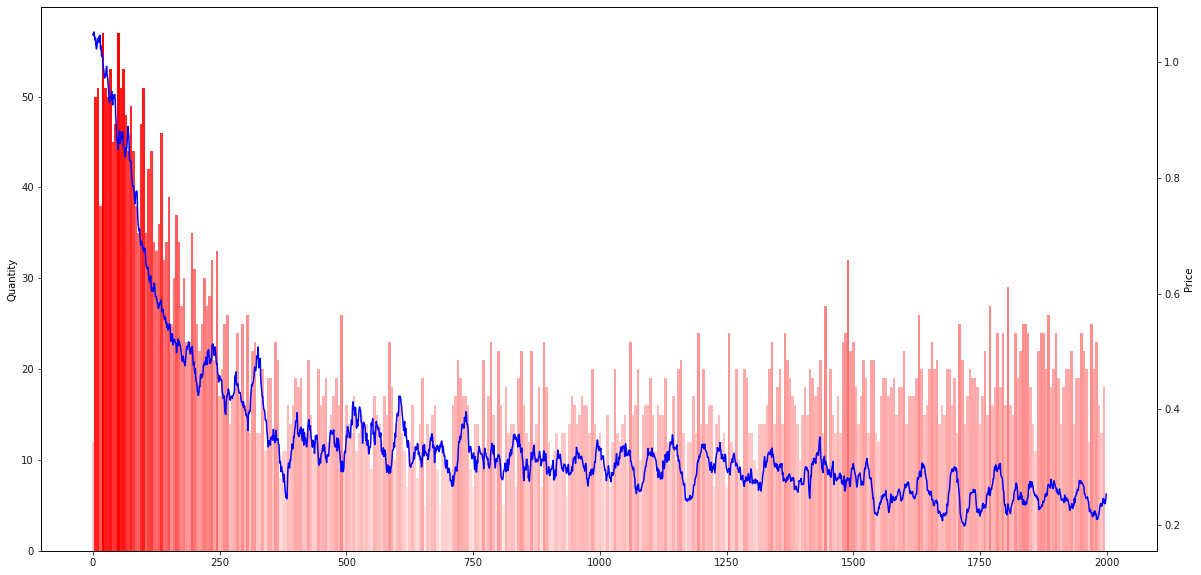

In [122]:
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

# Make bar to show the quantity
quantity_history = stats.get_total_quantity_history()
quantity_history_acc = []
amount_acc = 5
total = 0
for index,x in enumerate(quantity_history):
    total += x
    if index%amount_acc == 0:
        quantity_history_acc.append(total)
        total = 0
max_value = max(quantity_history_acc)
ax_left.bar([x*amount_acc for x in range(len(quantity_history_acc))], 
            quantity_history_acc, 
            width=amount_acc, 
            color=[(1,0,0,x/max_value) for x in quantity_history_acc])
ax_left.set_ylabel("Quantity")

# Show smooth price
smooth_price_history = get_smooth_plot(stats.get_price_history())
ax_right.plot(smooth_price_history, color='blue')
ax_right.set_ylabel("Price")


## Agent's money histogram

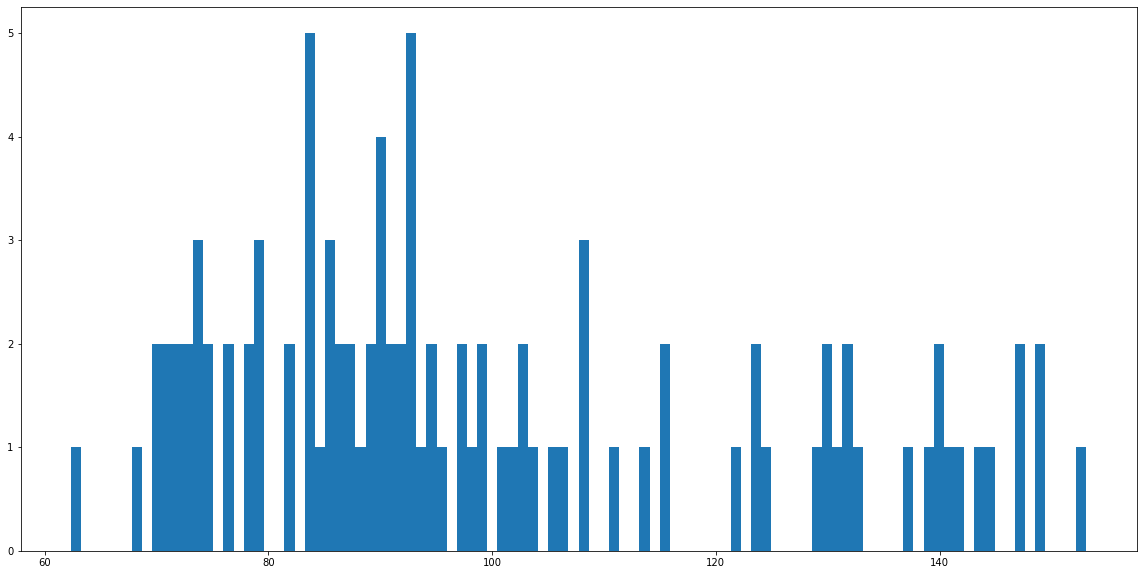

In [15]:
moneys = market.get_moneys()

bins = plt.hist(moneys, 100)

## Agent's quantity histogram

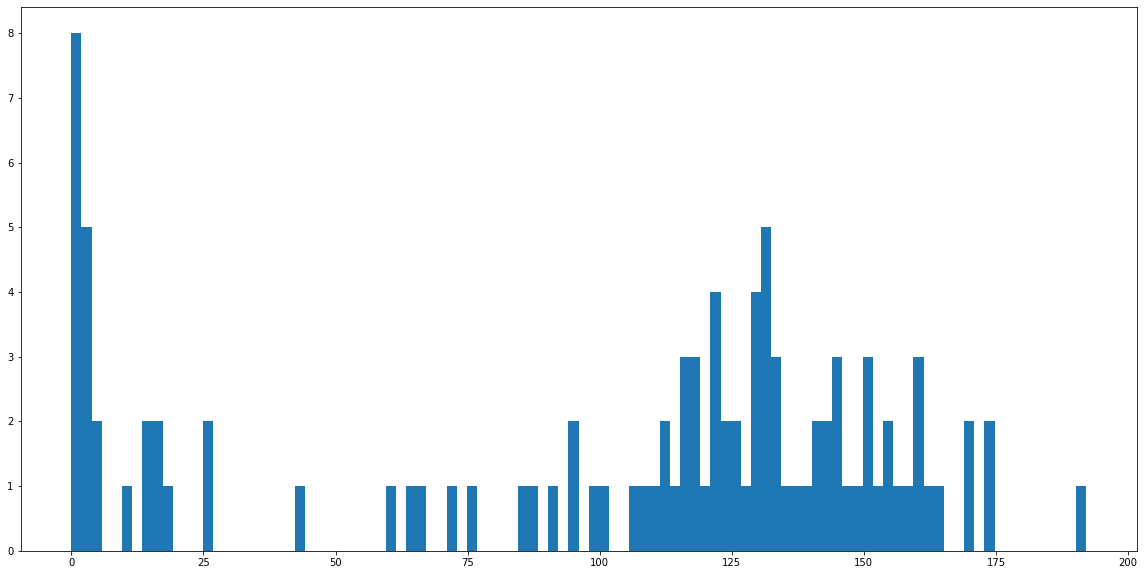

In [16]:
quantities = market.get_quantities()

bins = plt.hist(quantities, 100)

## Show for all agents their money and quantity

In [17]:
for a in range(AMOUNT_AGENTS):
    print(agents[a].get_name()+": Money {:.2f}, Quantity: {:.0f}".format(market.get_money(a), market.get_quantity(a)))

ActorCritic 0000: Money 89.69, Quantity: 116
ActorCritic 0001: Money 73.24, Quantity: 141
ActorCritic 0002: Money 106.72, Quantity: 85
ActorCritic 0003: Money 87.38, Quantity: 121
ActorCritic 0004: Money 115.47, Quantity: 61
ActorCritic 0005: Money 92.85, Quantity: 119
ActorCritic 0006: Money 71.88, Quantity: 161
ActorCritic 0007: Money 101.67, Quantity: 119
ActorCritic 0008: Money 89.76, Quantity: 112
ActorCritic 0009: Money 74.65, Quantity: 146
ActorCritic 0010: Money 76.16, Quantity: 165
ActorCritic 0011: Money 89.84, Quantity: 132
ActorCritic 0012: Money 82.26, Quantity: 129
ActorCritic 0013: Money 69.69, Quantity: 156
ActorCritic 0014: Money 115.72, Quantity: 64
ActorCritic 0015: Money 92.21, Quantity: 136
ActorCritic 0016: Money 147.42, Quantity: 4
ActorCritic 0017: Money 72.02, Quantity: 174
ActorCritic 0018: Money 140.64, Quantity: 2
ActorCritic 0019: Money 93.06, Quantity: 144
ActorCritic 0020: Money 100.83, Quantity: 110
ActorCritic 0021: Money 79.11, Quantity: 132
ActorCriti

## Pickup an agent and show info

In [18]:
PICKUP_AGENT = 32

agent_history = stats.get_agent_history(PICKUP_AGENT)
agent_training_history = stats.get_agent_training_history(PICKUP_AGENT)

### Accumulate reward

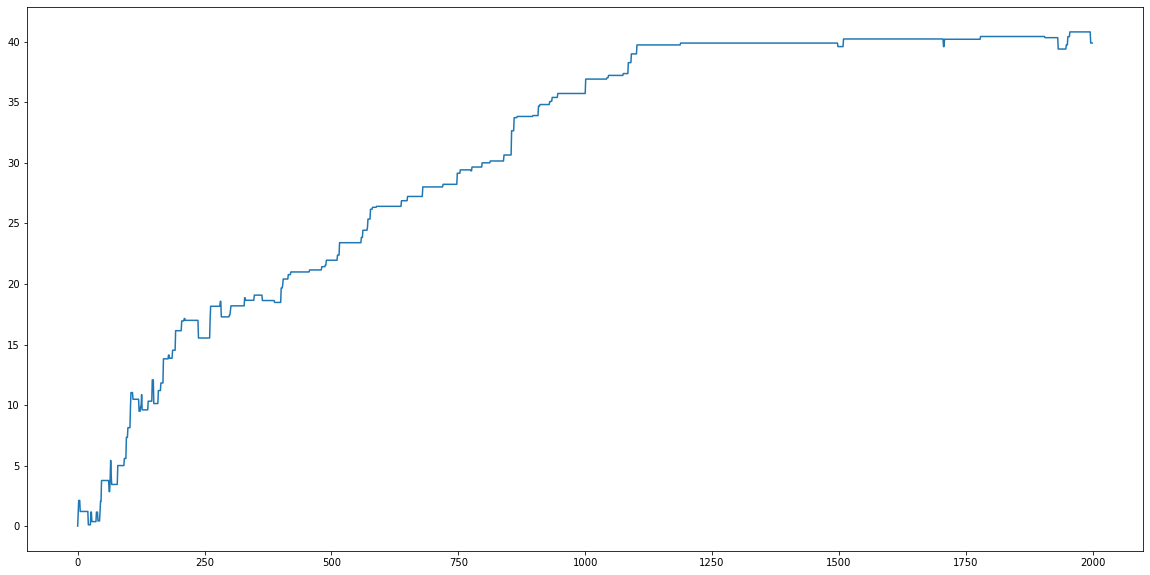

In [19]:
accumulate_reward = []
acc = 0
for x in agent_history['reward']:
    acc += x
    accumulate_reward.append(acc)
plt.plot(accumulate_reward)

### Plot losses

#### Loss action

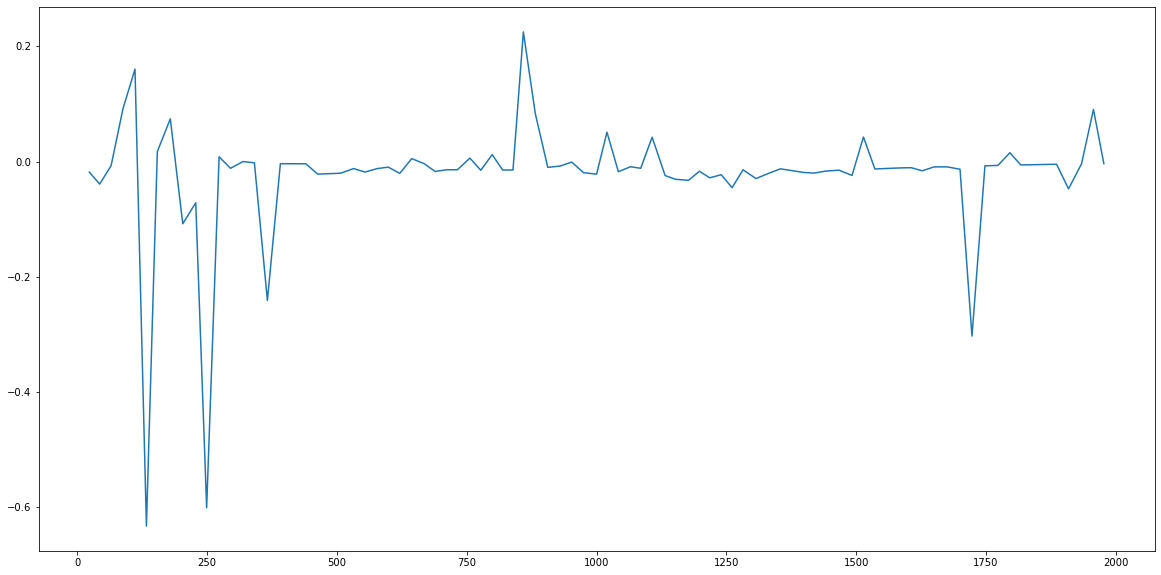

In [20]:
plt.plot(agent_training_history['steps'], agent_training_history['loss_action'])

#### Loss quantity action

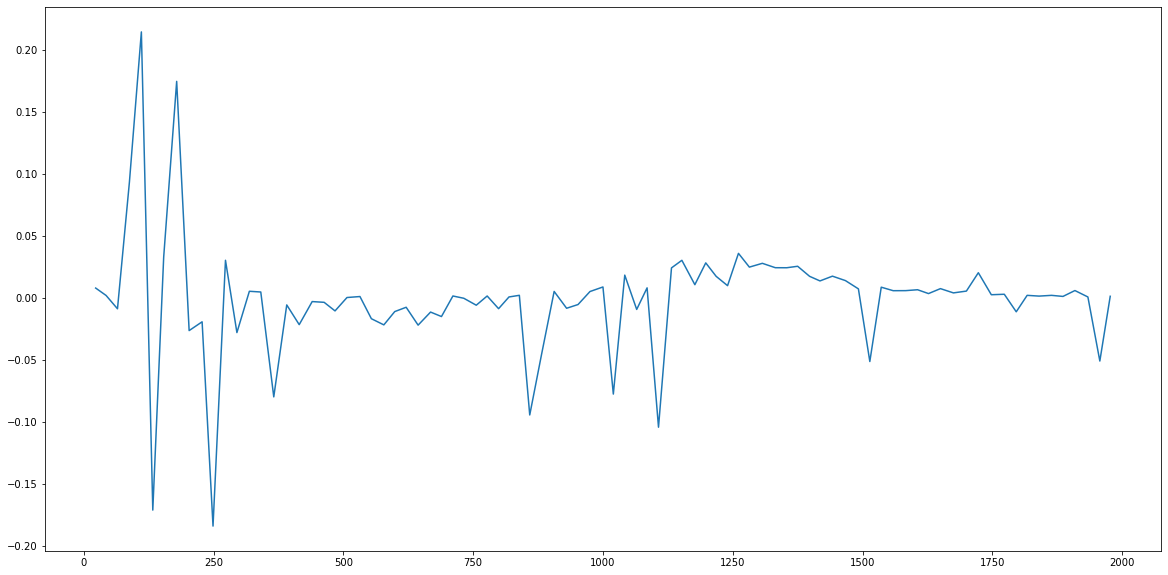

In [21]:
plt.plot(agent_training_history['steps'], agent_training_history['loss_quantity'])

#### Loss price action

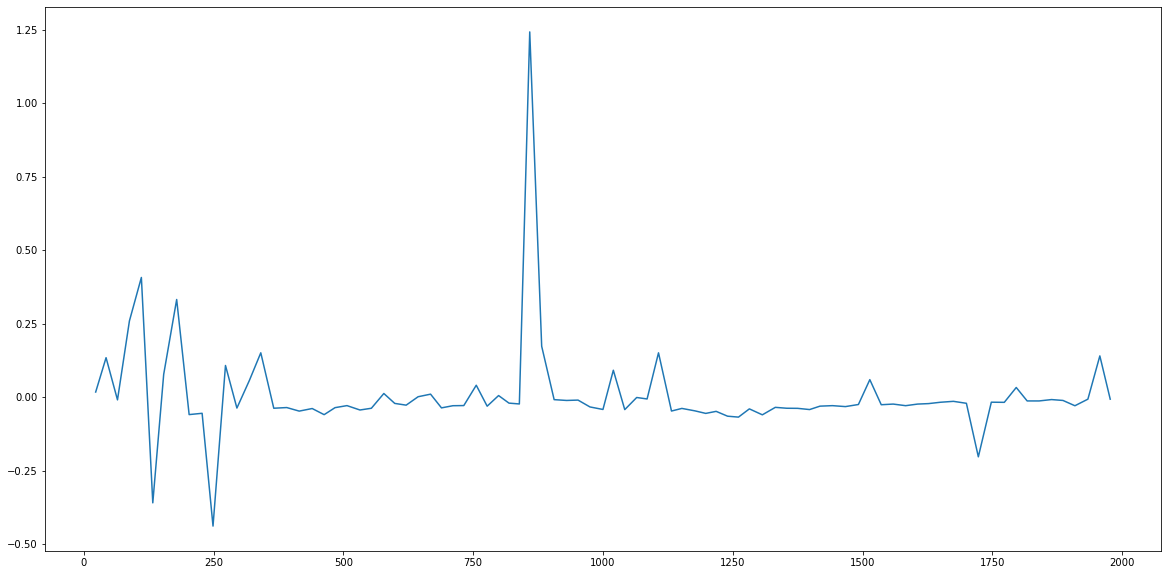

In [22]:
plt.plot(agent_training_history['steps'], agent_training_history['loss_price'])

#### Loss entropy

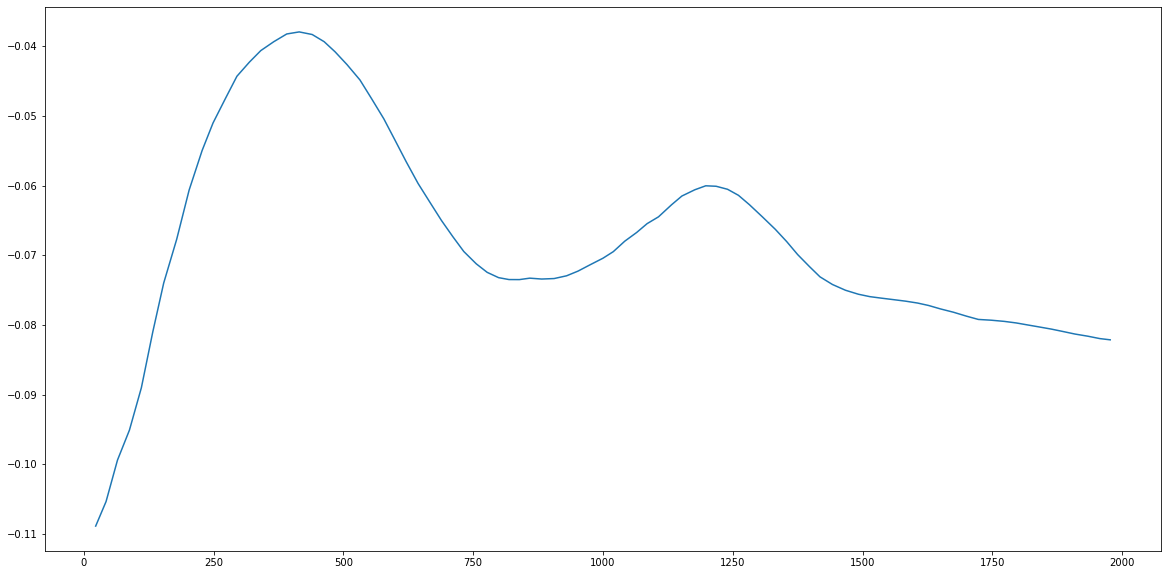

In [23]:
plt.plot(agent_training_history['steps'], agent_training_history['loss_entropy'])

#### Loss value

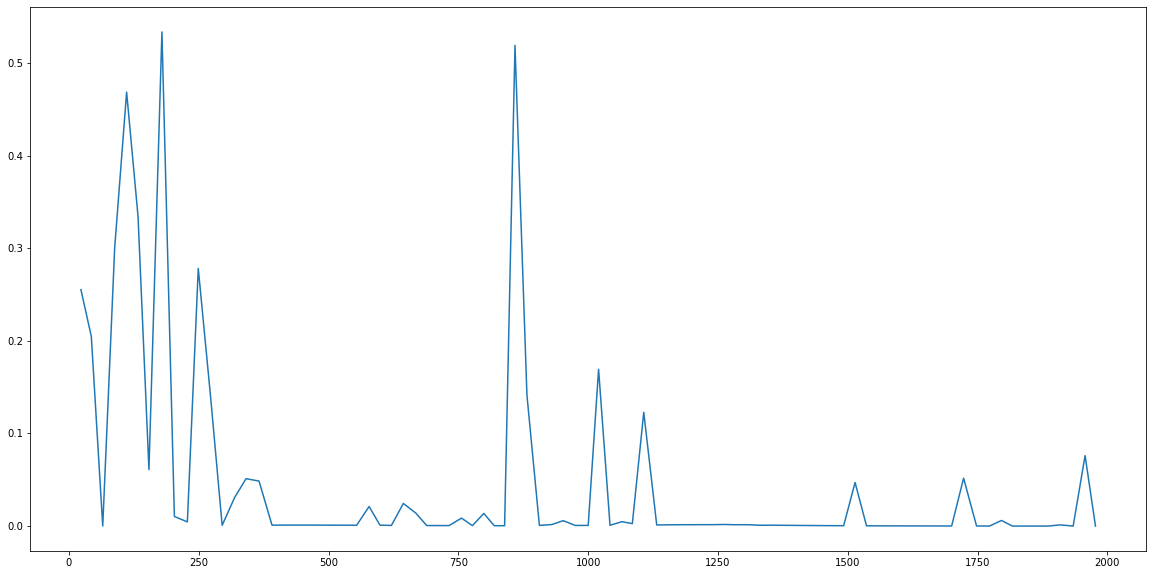

In [24]:
plt.plot(agent_training_history['steps'], agent_training_history['loss_value'])

### Value from net V(s) and Calculated value Q(s,a)

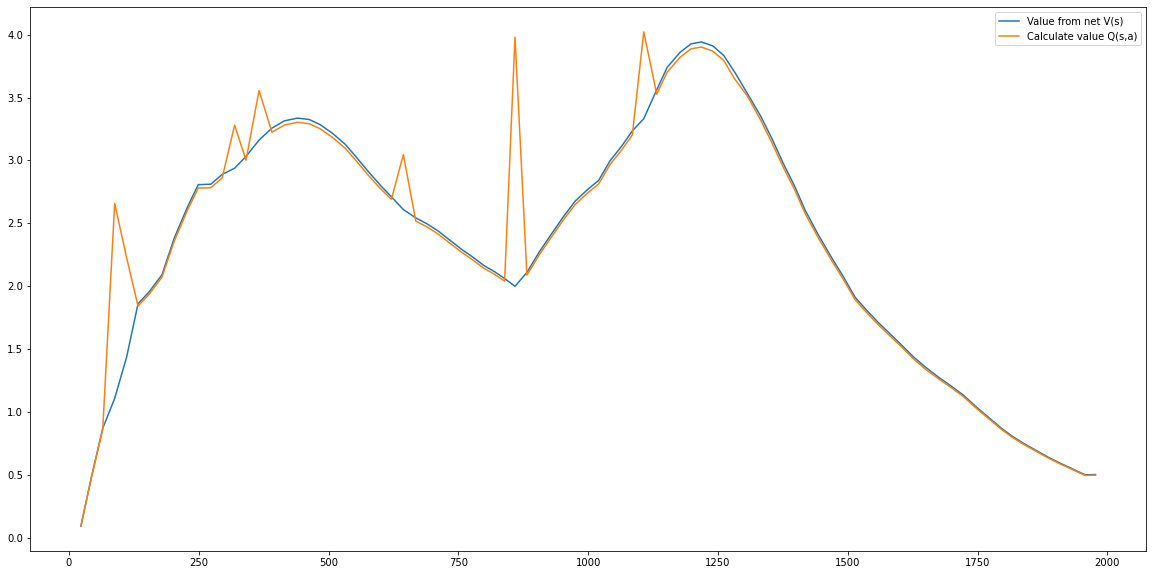

In [25]:
plt.plot(agent_training_history['steps'], agent_training_history['value_from_net'], label='Value from net V(s)')
plt.plot(agent_training_history['steps'], agent_training_history['calculate_value'], label='Calculate value Q(s,a)')
plt.legend()

## Animated plots

In [123]:
from matplotlib import animation
import pandas as pd 

### Price and quantity plot

In [157]:
smooth_price_history = get_smooth_plot(stats.get_price_history())

quantity_history = stats.get_total_quantity_history()
quantity_history_acc = []
amount_acc = 5
total = 0
for index,x in enumerate(quantity_history):
    total += x
    if index%amount_acc == 0:
        quantity_history_acc.append(total)
        total = 0
max_value = max(quantity_history_acc)
colors = [(1,0,0,x/max_value) for x in quantity_history_acc]
x_quantity_acc = [x*amount_acc for x in range(len(quantity_history_acc))]

In [ ]:
%matplotlib notebook

fig, ax_left = plt.subplots(figsize=(8,8))
ax_right = ax_left.twinx()

x_quantity_acc_partial = []
quantity_history_acc_partial = []
colors_partial = []
smooth_price_history_partial = []
    
def draw_graph(i):
    if i%amount_acc == 0:
        x_quantity_acc_partial.append(x_quantity_acc[i//amount_acc])
        quantity_history_acc_partial.append(quantity_history_acc[i//amount_acc])
        colors_partial.append(colors[i//amount_acc])
    smooth_price_history_partial.append(smooth_price_history[i])
        
    ax_left.cla()
    ax_right.cla()
    
    # Make bar to show the quantity
    ax_left.bar(x_quantity_acc_partial, quantity_history_acc_partial, width=amount_acc, color=colors_partial)
    ax_left.set_ylabel("Quantity", fontsize=20)
    ax_left.yaxis.label.set_color('red')
    
    # Show smooth price
    ax_right.plot(smooth_price_history_partial, color='blue')
    ax_right.set_ylabel("Price", fontsize=20)
    ax_right.yaxis.label.set_color('blue')
    
    ax_right.set_xlim(left=len(smooth_price_history_partial)-200)
    ax_right.set_ylim(bottom=0)
    
anima = animation.FuncAnimation(plt.gcf(), draw_graph, interval=10, save_count=2200)

writervideo = animation.FFMpegWriter(fps=60) 
anima.save("price_and_quantity_animation.mp4", writer=writervideo)

plt.show()

### Bar chart race

In [163]:
# Prepare the dataframe

moneys_history = [stats.get_agent_history(index_agent)['money'] for index_agent in range(AMOUNT_AGENTS) ]

# Invert dimension list
moneys_history = [list(x) for x  in zip(*moneys_history)]
#moneys_history = moneys_history[:40]

# Insert the agents init state
moneys_history.insert(0, [START_MONEY for x in range(AMOUNT_AGENTS)])

df = pd.DataFrame(moneys_history, index=[*range(len(moneys_history))], columns=[a.get_name() for a in agents])

In [ ]:
import bar_chart_race as bcr

# Price trick
prices = get_smooth_plot(stats.get_price_history())
#prices = prices[:40]
prices.insert(0, 0)
class PriceTrick:
    def format(self, x):
        return "Step: {:4.0f}, Price: {:.3f}".format(x, prices[int(x)])

bcr.bar_chart_race(
    df=df,
    filename='StockTradingRL.mp4',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=10,
    interpolate_period=False,
    label_bars=False,
    bar_size=.95,
    period_label={'x': .99, 'y': -0.075, 'ha': 'right', 'va': 'center'},
    period_fmt=PriceTrick(),
    period_length=50,
    figsize=(4, 4),
    dpi=250,
    cmap='dark12',
    bar_label_size=7,
    tick_label_size=7,
    shared_fontdict={'family' : 'Helvetica', 'color' : '.1'},
    scale='linear',
    writer=None,
    fig=None,
    bar_kwargs={'alpha': .7},
    filter_column_colors=False)  